In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


# -----------------------------
# 1) Load the Digits dataset
# -----------------------------
digits = load_digits(n_class=10)
X = digits.data.astype(np.float64)   # shape (n_samples, 64)
y = digits.target
n, d = X.shape

print("Digits X shape:", X.shape)
print("Digits y shape:", y.shape)


Digits X shape: (1797, 64)
Digits y shape: (1797,)


In [ ]:
# -----------------------------
# 2) Center data and covariance
#     C = 1/(n-1) * X^T X
# -----------------------------
mean_vec = X.mean(axis=0, keepdims=True)
X_centered = X - mean_vec

C = (X_centered.T @ X_centered) / (n - 1)
print("Covariance shape:", C.shape)


# -----------------------------
# 3) Eigen decomposition
#    (C is symmetric -> use eigh)
# -----------------------------
eigvals, eigvecs = np.linalg.eigh(C)  # ascending by default

# sort descending
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

print("Top 5 eigenvalues:", eigvals[:5])


Covariance shape: (64, 64)
Top 5 eigenvalues: [179.0069301  163.71774688 141.78843909 101.1003752   69.51316559]


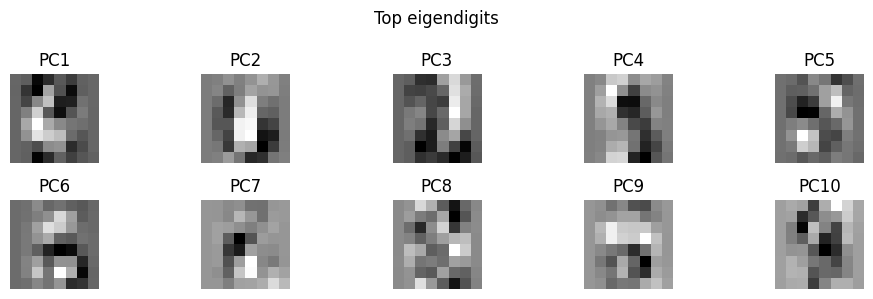

In [ ]:
# -----------------------------
# 4) Visualize top 10 eigendigits
# -----------------------------
def show_eigendigits(eigvecs, num=10, title="Top eigendigits"):
    plt.figure(figsize=(10, 3))
    for i in range(num):
        ax = plt.subplot(2, 5, i + 1)
        ax.imshow(eigvecs[:, i].reshape(8, 8), cmap="gray")
        ax.set_title(f"PC{i+1}")
        ax.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_eigendigits(eigvecs, num=10)


In [ ]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# -----------------------------
# Project + reconstruct
# -----------------------------
def project(Xc, eigvecs, k):
    W = eigvecs[:, :k]          # (64, k)
    Z = Xc @ W                  # (n, k)
    return Z

def reconstruct(Z, eigvecs, k, mean_vec):
    W = eigvecs[:, :k]          # (64, k)
    X_recon = Z @ W.T + mean_vec
    return X_recon


def visualize_recons_all_k_one_figure(
    X, X_centered, eigvecs, mean_vec,
    k_list=(5, 10, 20, 40, 64),
    num=6
):
    k_list = list(k_list)
    num = int(num)

    # Compute reconstructions once
    recons = {}
    for k in k_list:
        Z = project(X_centered, eigvecs, k)
        recons[k] = reconstruct(Z, eigvecs, k, mean_vec)

    # Layout: 1 row for originals + 1 row per k
    row_titles = ["Original"] + [f"Recon (k={k})" for k in k_list]
    rows = 1 + len(k_list)
    cols = num

    fig = make_subplots(
        rows=rows, cols=cols,
        row_titles=row_titles,
        horizontal_spacing=0.02,
        vertical_spacing=0.03
    )

    # --- Row 1: Originals ---
    for i in range(cols):
        img = X[i].reshape(8, 8)
        fig.add_trace(
            go.Heatmap(
                z=img,
                colorscale="Gray",
                showscale=False
            ),
            row=1, col=i+1
        )

    # --- Rows 2..: Reconstructions for each k ---
    for r, k in enumerate(k_list, start=2):
        X_recon = recons[k]
        for i in range(cols):
            img = X_recon[i].reshape(8, 8)
            fig.add_trace(
                go.Heatmap(
                    z=img,
                    colorscale="Gray",
                    showscale=False
                ),
                row=r, col=i+1
            )

    # Clean "image-like" look
    fig.update_yaxes(autorange="reversed")

    fig.update_xaxes(showticklabels=False, showgrid=False, zeroline=False)
    fig.update_yaxes(showticklabels=False, showgrid=False, zeroline=False)

    fig.update_layout(
        title="Digits Reconstruction Across k (One Figure)",
        height=170 * rows,
        width=140 * cols,
        margin=dict(l=30, r=20, t=60, b=10)
    )

    fig.show()


# -----------------------------
# Run
# -----------------------------
k_list = [5, 10, 20, 40, 64]
visualize_recons_all_k_one_figure(
    X=X,
    X_centered=X_centered,
    eigvecs=eigvecs,
    mean_vec=mean_vec,
    k_list=k_list,
    num=6
)


k= 1 -> Naive Bayes accuracy: 0.4000
k= 5 -> Naive Bayes accuracy: 0.8378
k=10 -> Naive Bayes accuracy: 0.8978
k=20 -> Naive Bayes accuracy: 0.9333
k=30 -> Naive Bayes accuracy: 0.9533
k=40 -> Naive Bayes accuracy: 0.9511
k=50 -> Naive Bayes accuracy: 0.9333
k=64 -> Naive Bayes accuracy: 0.8933


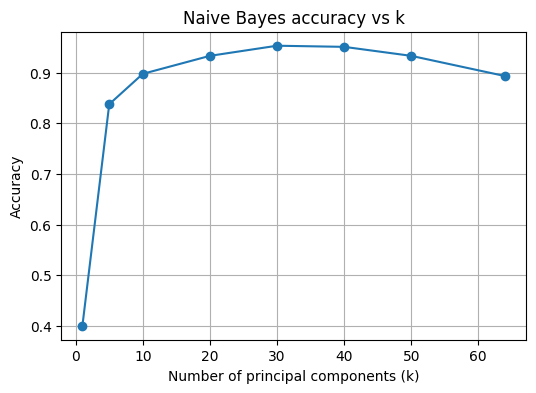

In [ ]:
# -----------------------------
# 6) Naive Bayes on reduced features
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_centered, y, test_size=0.25, random_state=42, stratify=y
)

def nb_accuracy_for_k(k):
    Z_train = project(X_train, eigvecs, k)
    Z_test  = project(X_test, eigvecs, k)

    clf = GaussianNB()
    clf.fit(Z_train, y_train)
    y_pred = clf.predict(Z_test)

    return accuracy_score(y_test, y_pred)

accs = []
for k in [1, 5, 10, 20, 30, 40, 50, 64]:
    acc = nb_accuracy_for_k(k)
    accs.append((k, acc))
    print(f"k={k:2d} -> Naive Bayes accuracy: {acc:.4f}")

# Optional quick plot
plt.figure(figsize=(6, 4))
plt.plot([k for k, _ in accs], [a for _, a in accs], marker="o")
plt.xlabel("Number of principal components (k)")
plt.ylabel("Accuracy")
plt.title("Naive Bayes accuracy vs k")
plt.grid(True)
plt.show()